In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

In [2]:
# Load the titanic dataset
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [3]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

<AxesSubplot:>

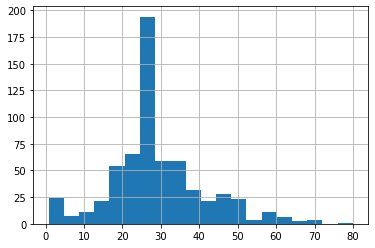

In [4]:
dftrain.age.hist(bins=20)

<AxesSubplot:>

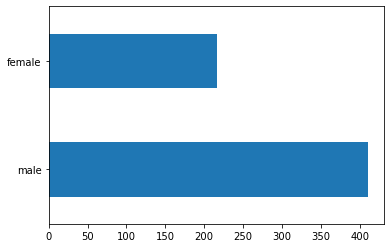

In [5]:
dftrain.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

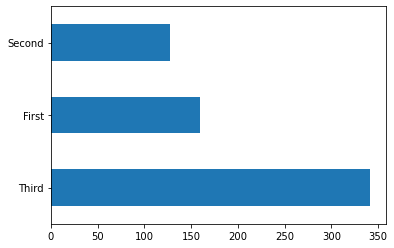

In [6]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

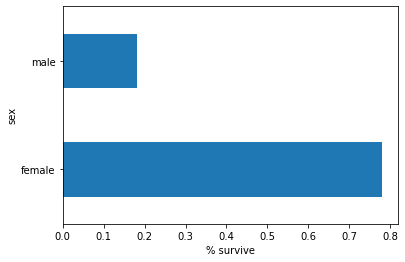

In [7]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [10]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [11]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [12]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [13]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'First' b'Third' b'Third' b'Second' b'Third' b'First' b'First' b'Second'
 b'Second' b'Second']

A batch of Labels: [0 0 0 0 0 0 1 0 1 0]


In [24]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns, optimizer='Ftrl')
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7613636, 'accuracy_baseline': 0.625, 'auc': 0.8370064, 'auc_precision_recall': 0.77968, 'average_loss': 0.473723, 'label/mean': 0.375, 'loss': 0.4659772, 'precision': 0.6875, 'prediction/mean': 0.35542476, 'recall': 0.6666667, 'global_step': 200}


In [16]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[27.],
       [45.],
       [25.],
       [39.],
       [18.],
       [37.],
       [27.],
       [39.],
       [30.],
       [59.]], dtype=float32)

In [17]:
feature_batch

{'sex': <tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'male', b'male', b'female', b'male', b'male', b'male', b'male',
        b'male', b'female', b'male'], dtype=object)>,
 'age': <tf.Tensor: shape=(10,), dtype=float64, numpy=array([27., 45., 25., 39., 18., 37., 27., 39., 30., 59.])>,
 'n_siblings_spouses': <tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 1, 0, 1, 0, 0, 0, 3, 0], dtype=int64)>,
 'parch': <tf.Tensor: shape=(10,), dtype=int64, numpy=array([2, 0, 0, 0, 1, 1, 0, 0, 0, 0], dtype=int64)>,
 'fare': <tf.Tensor: shape=(10,), dtype=float64, numpy=
 array([211.5   ,   6.975 ,   7.925 ,  13.    ,  20.2125,  29.7   ,
         76.7292,  13.    ,  21.    ,  13.5   ])>,
 'class': <tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'First', b'Third', b'Third', b'Second', b'Third', b'First',
        b'First', b'Second', b'Second', b'Second'], dtype=object)>,
 'deck': <tf.Tensor: shape=(10,), dtype=string, numpy=
 array([b'C', b'unknown', b'unknown', b'unknown', b'unk

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ADMINI~1\AppData\Local\Temp\tmp9f9894z2\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

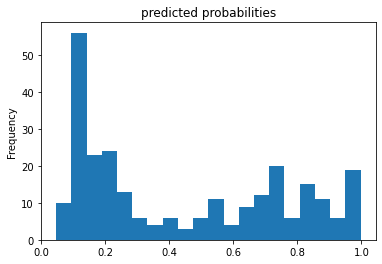

In [18]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [19]:
probs

0      0.103785
1      0.531761
2      0.823032
3      0.750510
4      0.360010
         ...   
259    0.859727
260    0.107653
261    0.652039
262    0.251284
263    0.530266
Length: 264, dtype: float64

(0.0, 1.05)

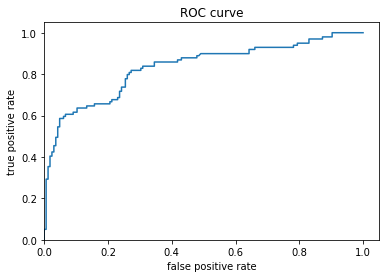

In [20]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

SyntaxError: invalid syntax (<ipython-input-23-c80949a63c2c>, line 1)